    Copyright(c) 2022-
    Author: Chaitanya Tejaswi (github.com/CRTejaswi)    License: GPLv3.0+

# MicroMagnetic Simulation: Skyrmion

Here, we simulate/visualise/analyse a single Neel Skyrmion in a disk with periodic boundary conditions.

The region is a $100nm$ wide disk of thickness $t=10nm$. 
Boundary Condition: Periodic in X & Y.

To create a skyrmion, we set magnetisation $(0,0,-1)$ in a small cylindrical element, and $(0,0,1)$ otherwise.

For disk geometry, we define the norm: $\sqrt{x^{2} + y^{2}} < \frac{r}{2}$.

C:\Users\me\AppData\Roaming\Python\Python311\site-packages\matplotlib\quiver.py:658: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\me\AppData\Roaming\Python\Python311\site-packages\matplotlib\quiver.py:658: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


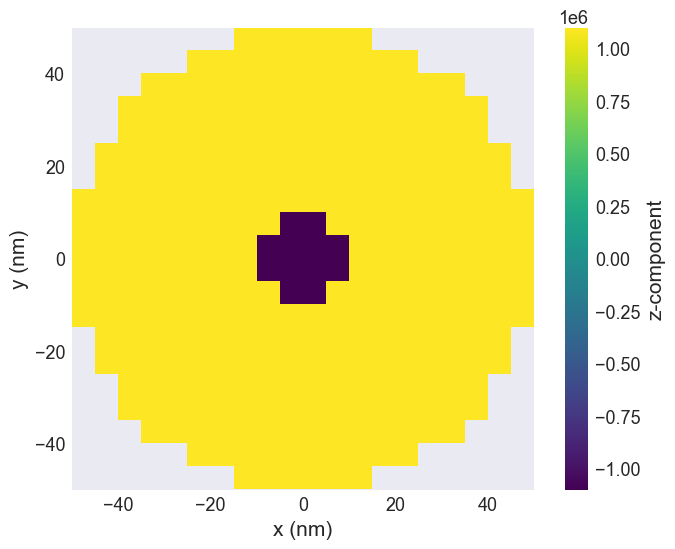

In [1]:
import micromagneticmodel as mm
import discretisedfield as df
import oommfc as mc
docker_runner = mc.oommf.DockerOOMMFRunner(image='oommf/oommf')

# Geometry
p1,p2 = (-50e-9,-50e-9,0), (50e-9,50e-9,10e-9)
cell = (5e-9, 5e-9, 5e-9)
region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell, bc='xy') # Periodic wrt x

system = mm.System(name='skyrmion1')

# Energies: zeeman, exchange, anisotropy, dmi (interficial)
H = (0,0,1e5)
A = 1.6e-11
K, u = 0.2e6, (0,0,1)
D = 4e-3

system.energy   = (mm.Zeeman(H=H)
                 + mm.Exchange(A=A)
                 + mm.UniaxialAnisotropy(K=K, u=u)
                 + mm.DMI(D=D, crystalclass='Cnv_z'))

# Initial Conditions: 
Ms = 1.1e6
def _Ms(point):
    x, y, z = point
    if (x**2 + y**2)**0.5 < 50e-9:
        return Ms
    else:
        return 0
    
def _m(point):
    x,y,z = point
    if (x**2 + y**2)**0.5 < 10e-9:
        return (0,0,-1)
    else:
        return (0,0,1)
    
# Initial State
system.m        = df.Field(mesh,dim=3,value=_m, norm=_Ms)
system.m.plane('z').mpl()

In [2]:
system.energy

Zeeman(H=(0, 0, 100000.0)) + Exchange(A=1.6e-11) + UniaxialAnisotropy(K=200000.0, u=(0, 0, 1)) + DMI(D=0.004, crystalclass='Cnv_z')

In [3]:
system.dynamics

Dynamics()

Running OOMMF (DockerOOMMFRunner)[2022/11/10 04:33]... (1.6 s)


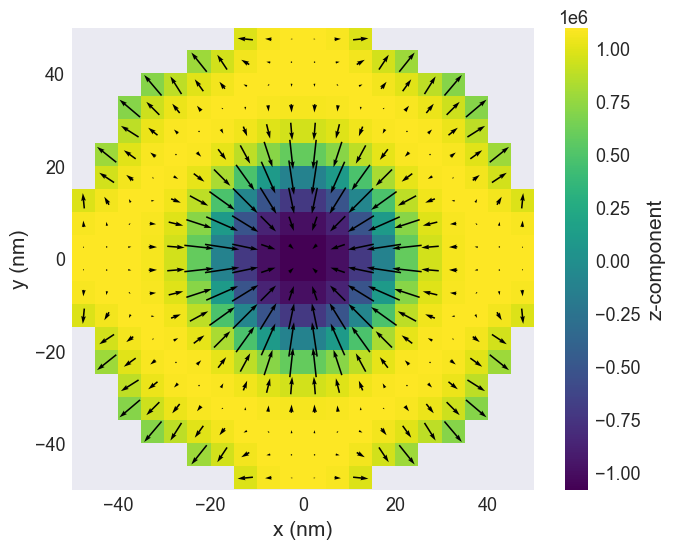

In [4]:
# Relaxed State
driver = mc.MinDriver()
driver.drive(system, runner=docker_runner)
system.m.plane('z').mpl()

We can visualise __magnetisation__ ($\vec{m_{x}}, \vec{m_{y}}, \vec{m_{z}}$) along an axis passing through the centre of the cylinder.

This helps us understand how magnetisation changes for an element passing through this field (to model behaviour for a passing current).

As visible, there's a spin-flip for X, Z components.

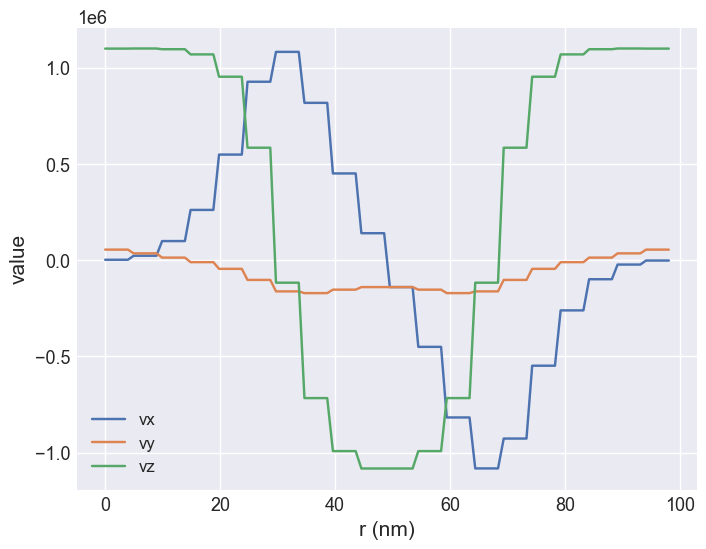

In [7]:
p1, p2 = (-49e-9, 0, 0), (49e-9, 0, 0)
system.m.line(p1=p1, p2=p2, n=100).mpl()